In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from census_utils import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
from geopy import distance
from shapely.geometry import LineString

# Data Processing
## Load synthetic data

In [2]:
DEMO_COLS = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']

In [3]:
synth_df = pd.read_csv(get_synthetic_out_file())
synth_df.head()

,YEAR,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,TRACTA,BLKGRPA,BLOCKA,NAME,...,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,HH_NUM,ACCURACY,AGE_ACCURACY,identifier
0,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,2,0,2,0,1,True,19601001000
1,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,1,1,True,19601001000
2,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,2,1,True,19601001000
3,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,3,1,True,19601001000
4,2010,Vermont,50,Addison County,1,70075,960100,1,1000,Block 1000,...,0,0,0,0,0,1,4,1,True,19601001000


In [4]:
swapped_df = pd.read_csv(get_swapped_file())
swapped_df.rename(columns={'county': 'COUNTYA', 'tract': 'TRACTA', 'X18_PLUS': '18_PLUS'}, inplace=True)
swapped_df.head()

,Unnamed: 0,YEAR,STATE,STATEA,COUNTY,COUSUBA,BLKGRPA,BLOCKA,NAME,BLOCK_TOTAL,...,AGE_ACCURACY,identifier,freq,U,swapped,prob,TRACTA,COUNTYA,blockid,household.id
0,1,2010,Vermont,50,Bennington County,1450,2,1108,Block 2022,1,...,True,39707002022,14,4,1,1.0,970300,3,970700-003-2022,970300-003-1108-0001
1,2,2010,Vermont,50,Franklin County,59125,2,2034,Block 2046,1,...,True,11103002046,14,4,1,1.0,10300,11,010300-011-2046,010300-011-2034-0001
2,3,2010,Vermont,50,Grand Isle County,67000,4,4044,Block 4038,1,...,True,13202004038,14,4,1,1.0,20200,13,020200-013-4038,020200-013-4044-0001
3,4,2010,Vermont,50,Windham County,43375,2,1026,Block 2021,1,...,True,259682002021,14,4,1,1.0,967900,25,968200-025-2021,967900-025-1026-0001
4,5,2010,Vermont,50,Windsor County,84925,1,1000,Block 1018,1,...,True,279660001018,14,4,1,1.0,966000,27,966000-027-1018,966000-027-1000-0001


## Join the two together
For the swapped data, `household.id` countains the destination block and `blockid` contains the source block

In [5]:
ID_COLS = ['TRACTA', 'COUNTYA', 'BLOCKA']
def make_identifier_synth(df):
    id_lens = [6, 3, 4]
    str_cols = [col + '_str' for col in ID_COLS]
    for col, l, col_s in zip(ID_COLS, id_lens, str_cols):
        assert max(num_digits(s) for s in df[col].unique()) <= l
        df[col_s] = df[col].astype(str).str.zfill(l)
    df['id'] = df[str_cols].astype(str).agg('-'.join, axis=1)
    for col_s in str_cols:
        del df[col_s]
        
def make_identifier_swapped(df):
    df['id'] = df['household.id'].str.replace('-[0-9]+$', '')

In [6]:
make_identifier_synth(synth_df)
make_identifier_swapped(swapped_df)

/var/folders/8_/y856fj8d3fx5mhg4ch9grjd80000gn/T/ipykernel_46854/4037533128.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['household.id'].str.replace('-[0-9]+$', '')


In [7]:
def aggregate_to_block_synth(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['AGE_ACCURACY'] = np.mean
    agg_dict['ACCURACY'] = np.mean
    df['NUM_HH'] = np.ones(len(df))
    agg_dict['NUM_HH'] = 'count'
    agg_df = df.groupby(['id', 'COUNTYA', 'TRACTA', 'BLOCKA']).agg(agg_dict).reset_index()
    return agg_df

def aggregate_to_block_swapped(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['swapped'] = np.sum
    agg_df = df.groupby(['id']).agg(agg_dict).reset_index()
    return agg_df

In [8]:
synth_agg = aggregate_to_block_synth(synth_df)
print(len(synth_agg))
synth_agg.head()

17541


,id,COUNTYA,TRACTA,BLOCKA,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,AGE_ACCURACY,ACCURACY,NUM_HH
0,000100-007-1001,7,100,1001,66,59,7,0,0,0,0,0,4,51,1.0,2.0,28
1,000100-007-1002,7,100,1002,8,6,0,0,0,0,0,2,0,4,1.0,1.0,2
2,000100-007-1004,7,100,1004,36,36,0,0,0,0,0,0,4,26,1.0,1.0,14
3,000100-007-1005,7,100,1005,35,27,8,0,0,0,0,0,0,28,1.0,2.0,12
4,000100-007-1008,7,100,1008,720,605,23,3,61,0,5,23,21,558,1.0,2.0,290


In [9]:
swapped_agg = aggregate_to_block_swapped(swapped_df)
print(len(swapped_agg))
swapped_agg.head()

17541


,id,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,swapped
0,000100-007-1001,66,59,7,0,0,0,0,0,4,51,0
1,000100-007-1002,8,8,0,0,0,0,0,0,0,4,2
2,000100-007-1004,36,36,0,0,0,0,0,0,4,26,0
3,000100-007-1005,35,27,8,0,0,0,0,0,0,28,0
4,000100-007-1008,720,605,23,3,61,0,5,23,21,558,0


In [10]:
def merge_synth_swapped(synth_agg, swapped_agg):
    df = synth_agg.merge(swapped_agg,
                        how='inner',
                        on='id',
                        suffixes=('_sy', '_sw'),
                        validate='one_to_one')
    return df

In [40]:
orig_df = merge_synth_swapped(synth_agg, swapped_agg)

## Load map data

In [12]:
def load_shape_data(area):
    block_map = gpd.read_file(get_shape_file(area))
    return block_map.to_crs("EPSG:3395")

In [13]:
maps = {area: load_shape_data(area) for area in get_shape_file.AREAS}

In [15]:
block_map = maps['BLOCK']
statefp = block_map['STATEFP10'].unique()[0]

In [16]:
for area, m in maps.items():
    if area not in ['BLOCK', 'BLOCK_GROUP']:
        m.drop(m[m['STATEFP10'] != statefp].index, inplace=True)

In [17]:
block_map.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GISJOIN,Shape_Area,Shape_len,geometry
0,50,001,961000,1066,500019610001066,Block 1066,G5040,None,None,S,66368.0,0.0,+43.9053063,-073.0819173,G50000109610001066,66368.017716,1856.491082,"POLYGON ((-8135282.154 5421251.873, -8135273.8..."
1,50,001,961000,1026,500019610001026,Block 1026,G5040,None,None,S,21966.0,0.0,+43.9541479,-073.1343633,G50000109610001026,21965.560825,625.344558,"POLYGON ((-8141266.245 5428517.638, -8141277.2..."
2,50,001,961000,1083,500019610001083,Block 1083,G5040,None,None,S,17084.0,0.0,+43.9048183,-073.0635069,G50000109610001083,17083.933569,529.044846,"POLYGON ((-8133321.150 5421000.446, -8133325.8..."
3,50,001,961000,1007,500019610001007,Block 1007,G5040,None,None,S,273.0,0.0,+43.9238605,-073.0844993,G50000109610001007,273.126674,137.317265,"POLYGON ((-8135715.521 5423949.499, -8135719.1..."
4,50,001,960900,3055,500019609003055,Block 3055,G5040,None,None,S,0.0,4686.0,+43.8725811,-073.2686426,G50000109609003055,4685.346797,318.855936,"POLYGON ((-8156231.481 5416041.827, -8156249.8..."


In [39]:
def make_GISJOIN(df):
    block_df = pd.read_csv(get_block_file())
    block_df = block_df[['GISJOIN', 'COUNTYA', 'TRACTA', 'BLOCKA', 'SLDUA', 'SLDLA']]
    return df.merge(block_df,
             how='inner',
             on=['COUNTYA', 'TRACTA', 'BLOCKA'],
             validate='one_to_one')

def cols_to_str(df):
    df['COUNTYFP10'] = df['COUNTYA'].astype(str).str.zfill(3)
    df['TRACTCE10'] = df['TRACTA'].astype(str).str.zfill(6)
    df['BLOCKCE10'] = df['BLOCKA'].astype(str).str.zfill(4)

In [77]:
cols_to_str(orig_df)
orig_df = make_GISJOIN(orig_df)

In [78]:
orig_df.head()

,id,COUNTYA,TRACTA,BLOCKA,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,...,TWO_OR_MORE_sw,NUM_HISP_sw,18_PLUS_sw,swapped,COUNTYFP10,TRACTCE10,BLOCKCE10,GISJOIN,SLDUA,SLDLA
0,000100-007-1001,7,100,1001,66,59,7,0,0,0,...,0,4,51,0,007,000100,1001,G50000700001001001,CHI,C31
1,000100-007-1002,7,100,1002,8,6,0,0,0,0,...,0,0,4,2,007,000100,1002,G50000700001001002,CHI,C31
2,000100-007-1004,7,100,1004,36,36,0,0,0,0,...,0,4,26,0,007,000100,1004,G50000700001001004,CHI,C31
3,000100-007-1005,7,100,1005,35,27,8,0,0,0,...,0,0,28,0,007,000100,1005,G50000700001001005,CHI,C31
4,000100-007-1008,7,100,1008,720,605,23,3,61,0,...,23,21,558,0,007,000100,1008,G50000700001001008,CHI,C31


In [79]:
def get_aggregated_df(df, col):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col + '_sw' : np.sum for col in demo_cols}
    agg_dict['swapped'] = np.sum
    agg_dict['NUM_HH'] = np.sum
    agg_dict.update({col + '_sy' : np.sum for col in demo_cols})
    return df.groupby(col).agg(agg_dict)

In [125]:
def get_geo_at_area(area):
    cols = {'BLOCK': ['COUNTYFP10', 'TRACTCE10', 'BLOCKCE10'],
            'UP_LEG': 'SLDUA',
            'LOW_LEG': 'SLDLA',
            'COUNTY': 'COUNTYFP10',
            'TRACT': ['COUNTYFP10', 'TRACTCE10']}
    if cols[area]:
        df = get_aggregated_df(orig_df, cols[area])
    else:
        df = orig_df
    map_df = maps[area]
    if area == 'LOW_LEG':
        return map_df.merge(df,
                            how='left',
                            left_on='SLDLST10',
                            right_on=cols[area],
                            validate='one_to_one')
    elif area == 'UP_LEG':
        return map_df.merge(df,
                            how='left',
                            left_on='SLDUST10',
                            right_on=cols[area],
                            validate='one_to_one')
    return map_df.merge(df,
                 how='left',
                 on=cols[area],
                 validate='one_to_one')

def add_geo(df, map_df):
    return map_df.merge(df,
                        how='left',
                        on='GISJOIN',
                        validate='one_to_one')

# Analysis

In [169]:
plot_level = 'UP_LEG'
df = get_geo_at_area(plot_level)
print(len(df), 'regions at level', plot_level)
df.head()

13 regions at level UP_LEG


,STATEFP10,SLDUST10,GEOID10,NAMELSAD10,LSAD10,LSY10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,OTH_sy,TWO_OR_MORE_sy,NUM_HISP_sy,18_PLUS_sy
0,50,FRA,50FRA,Franklin State Senate District,L8,2010,G5210,N,1458677858,201010905,...,46235,44143,203,507,224,13,127,1018,553,34696
1,50,LAM,50LAM,Lamoille State Senate District,L8,2010,G5210,N,923865581,9210916,...,21476,20730,140,77,119,3,77,330,299,16622
2,50,WSR,50WSR,Windsor State Senate District,L8,2010,G5210,N,2510570288,19288908,...,56670,54563,327,154,529,13,141,943,696,45192
3,50,WAS,50WAS,Washington State Senate District,L8,2010,G5210,N,1779926134,21213229,...,59534,57192,441,151,502,11,185,1052,995,46571
4,50,WDM,50WDM,Windham State Senate District,L8,2010,G5210,N,1931128466,27824624,...,42637,40570,417,109,451,19,210,861,791,33930


In [170]:
print('Total number of households involved in a swap:', df['swapped'].sum())
print('Swap rate:', df['swapped'].sum() / df['NUM_HH'].sum())

Total number of households involved in a swap: 24422
Swap rate: 0.09300465746851544


In [171]:
def plot_column(df, col, title=''):
    fig, ax = plt.subplots(figsize=(12, 12))
    df.plot(ax=ax,
            column=col,
            cmap='Reds',
            legend=True,
            missing_kwds={'color': 'grey'})
    #maps['UP_LEG'].plot(ax=ax, facecolor='none', edgecolor='black', linewidth=.2)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    return ax

<AxesSubplot:title={'center':'Population'}>

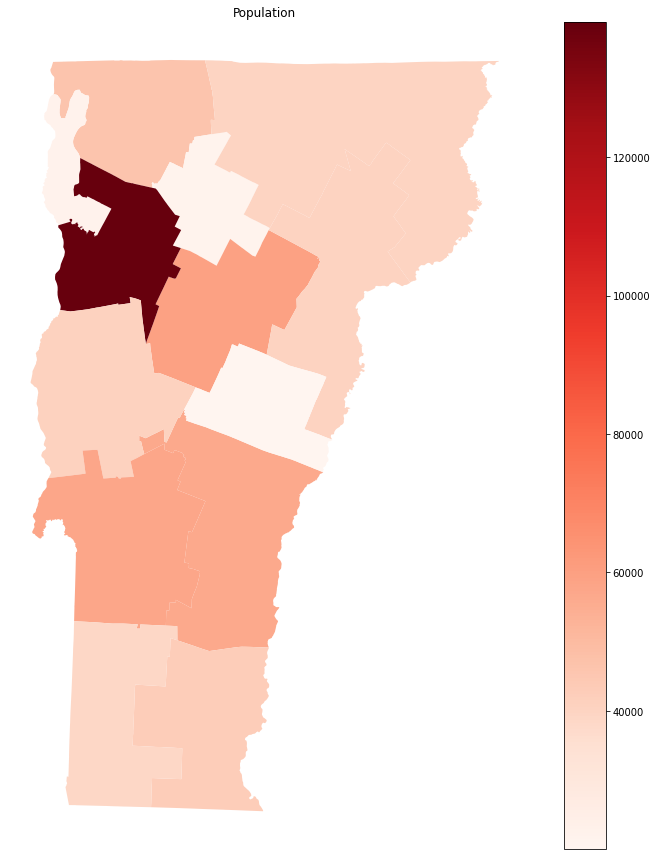

In [172]:
plot_column(df, 'TOTAL_sy', 'Population')

<AxesSubplot:title={'center':'Number of swaps'}>

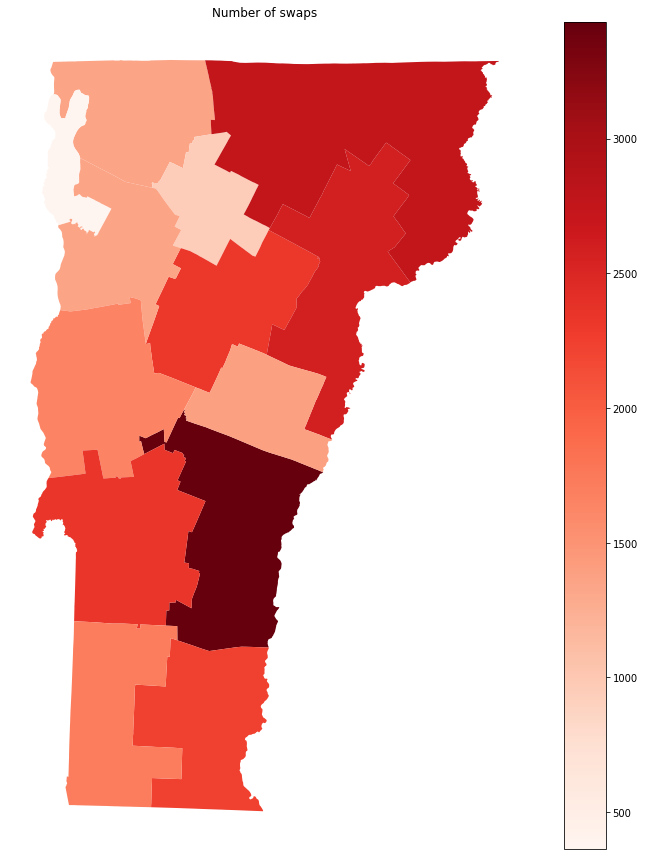

In [173]:
plot_column(df, 'swapped', 'Number of swaps')

## Race/ethnicity changes

In [156]:
def r_eth_changes(df):
    diffs = None
    r_eth_cols = ['W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP']
    for c in r_eth_cols:
        if diffs is None:
            diffs = np.abs(df[c + '_sw'] - df[c + '_sy'])
        else:
            diffs += np.abs(df[c + '_sw'] - df[c + '_sy'])
    print('Total number of blocks where race/eth counts changed:', diffs.sum())
    c_name = 'r_eth_diff'
    df[c_name] = diffs
    plot_column(df, c_name, 'Change in race/eth counts')
    del df[c_name]

Total number of blocks where race/eth counts changed: 426


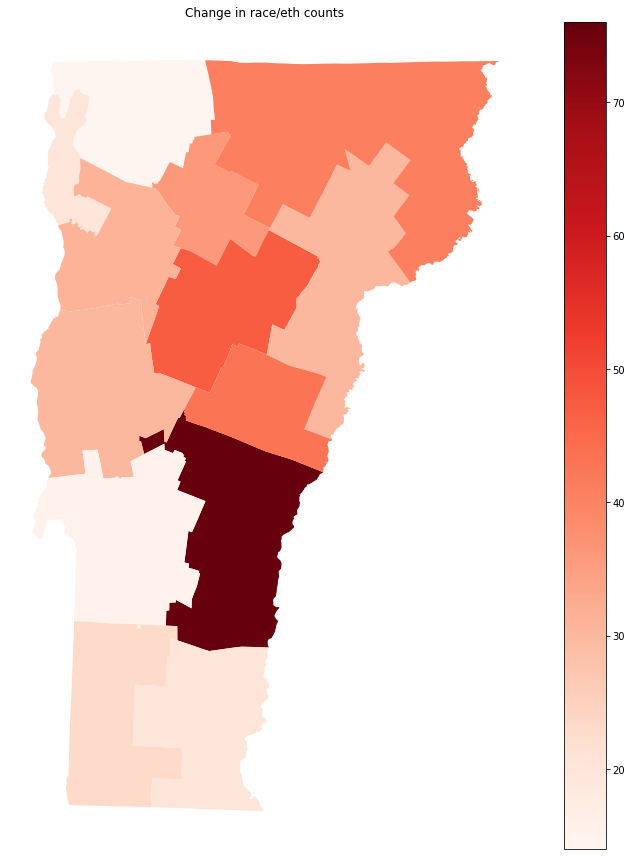

In [157]:
r_eth_changes(df)

In [135]:
def pct_white_changes(df):
    before_pct_white = df['W_sy'] / df['TOTAL_sy']
    after_pct_white = df['W_sw'] / df['TOTAL_sw']
    c_name = 'pct_white_change'
    df[c_name] = np.abs(after_pct_white - before_pct_white)
    plot_column(df, c_name, 'Change in fraction white')
    del df[c_name]

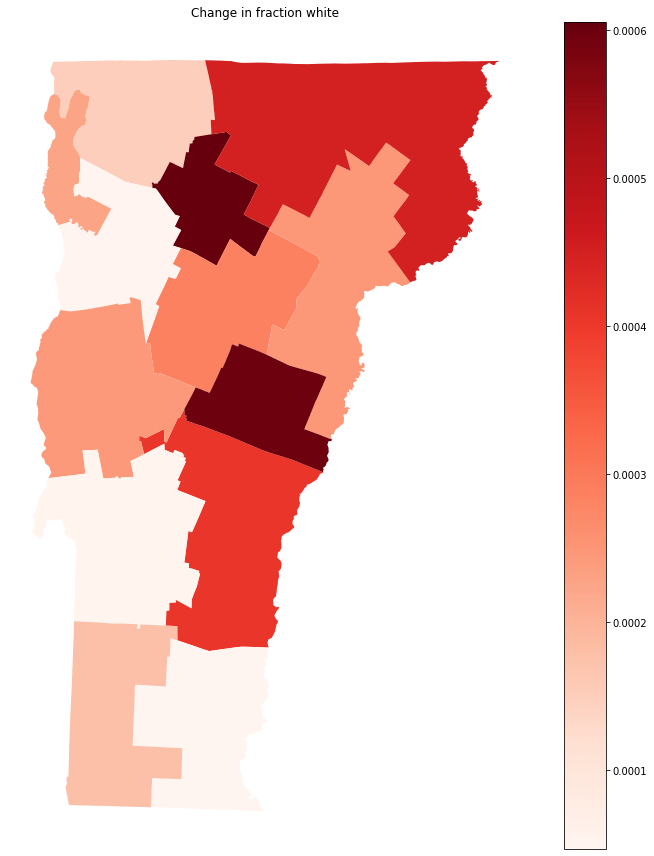

In [136]:
pct_white_changes(df)

## Racial analysis
Here, we look at the change in percent white at the voting district level (state lower and upper assemblies) as well as county and tract levels.

In [85]:
def pct_white_changes_stats(df, col):
    grouped = get_aggregated_df(df, col)
    print('There are', len(grouped), col + "'s")
    before_pct_white = grouped['W_sy'] / grouped['TOTAL_sy']
    after_pct_white = grouped['W_sw'] / grouped['TOTAL_sw']
    diff = after_pct_white - before_pct_white
    print('Largest absolute change in fraction white: {:.3g}'.format(np.max(np.abs(diff))))
    plt.figure()
    diff.plot.hist()
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.title('Change in fraction white at ' + col)

There are 108 SLDLA's
Largest absolute change in fraction white: 0.00471
There are 13 SLDUA's
Largest absolute change in fraction white: 0.000605
There are 14 COUNTYA's
Largest absolute change in fraction white: 0.00129
There are 183 TRACTA's
Largest absolute change in fraction white: 0.00804


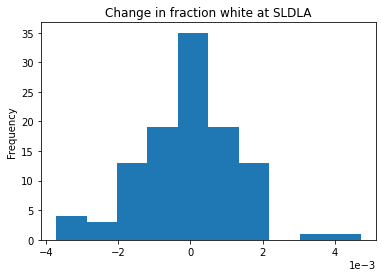

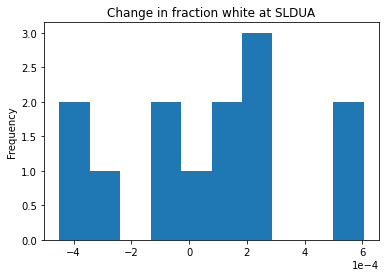

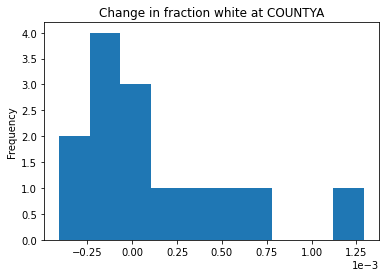

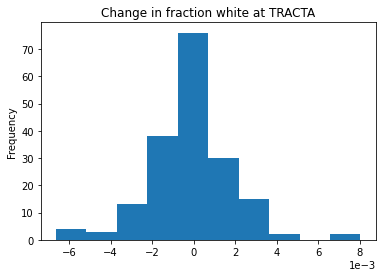

In [87]:
pct_white_changes_stats(orig_df, 'SLDLA')
pct_white_changes_stats(orig_df, 'SLDUA')
pct_white_changes_stats(orig_df, 'COUNTYA')
pct_white_changes_stats(orig_df, 'TRACTA')

## Majority minority district analysis
There are no MMDs in Vermont, so we wouldn't expect an effect here. But this code will be useful in the future.

In [88]:
def mmd_analysis(df, col):
    df = get_aggregated_df(df, col)
    before_mmd = df['W_sy'] / df['TOTAL_sy'] < .5
    after_mmd = df['W_sw'] / df['TOTAL_sw'] < .5
    change = before_mmd != after_mmd
    num_changes = change.sum()
    plt.figure()
    (df['W_sw'] / df['TOTAL_sw']).plot.hist(label=col)
    plt.title('Fraction white (swapped) ' + col)
    print('Number of MMD changes at', col, 'level:', num_changes, 'out of', len(df))

Number of MMD changes at SLDLA level: 0 out of 108
Number of MMD changes at SLDUA level: 0 out of 13
Number of MMD changes at COUNTYA level: 0 out of 14
Number of MMD changes at TRACTA level: 0 out of 183


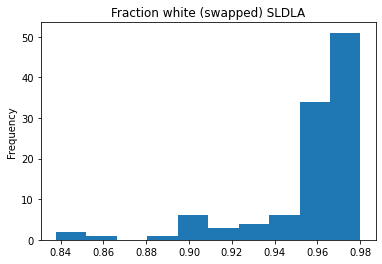

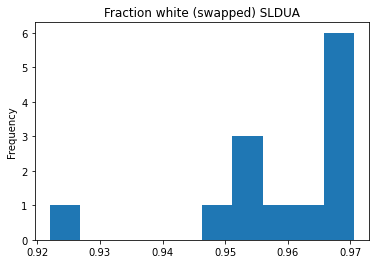

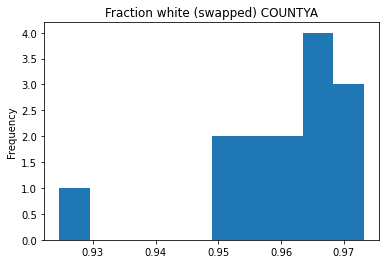

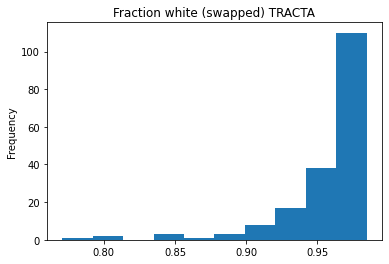

In [90]:
for level in ['SLDLA', 'SLDUA', 'COUNTYA', 'TRACTA']:
    mmd_analysis(orig_df, level)

## Relationships to racial inaccuracy
We can look at the change in fraction white as a function of the population in the region in question (lower assembly district, upper assembly district, county, tract) and the fraction of the population that is white.

In [158]:
def add_pct_white(grouped):
    before_pct_white = grouped['W_sy'] / grouped['TOTAL_sy']
    after_pct_white = grouped['W_sw'] / grouped['TOTAL_sw']
    grouped['frac_white_change'] = after_pct_white - before_pct_white
    grouped['frac_white'] = before_pct_white

def plot_frac_white_relationships(df, col):
    grouped = get_aggregated_df(df, col)
    add_pct_white(grouped)
    grouped.plot.scatter(x='TOTAL_sy', y='frac_white_change')
    plt.title(col)
    grouped.plot.scatter(x='frac_white', y='frac_white_change')
    plt.title(col)
#     grouped['abs_white_change'] = np.abs(grouped['frac_white_change'])
#     grouped.plot.scatter(x='frac_white', y='abs_white_change')
#     plot_best_fit(grouped['frac_white'], grouped['abs_white_change'])
#     plt.title(col)

def plot_best_fit(x, y):
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

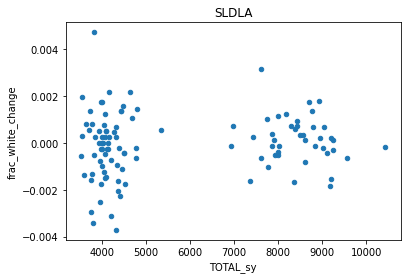

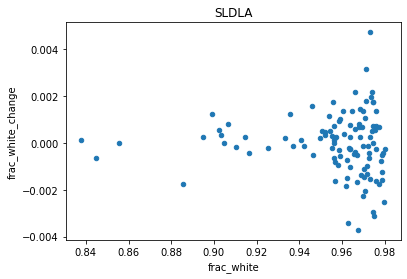

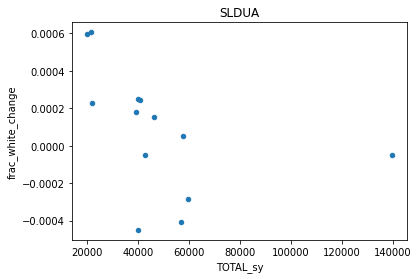

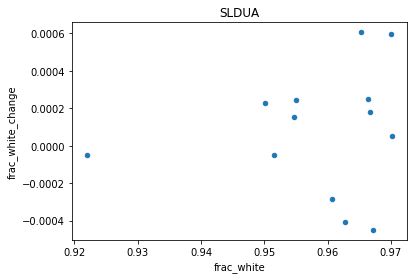

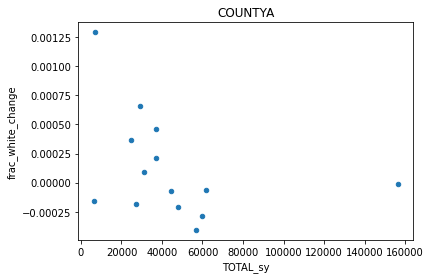

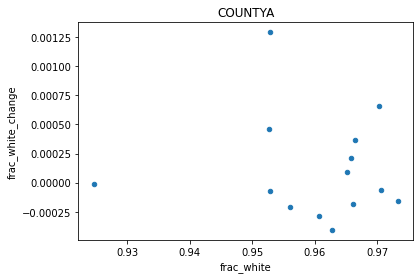

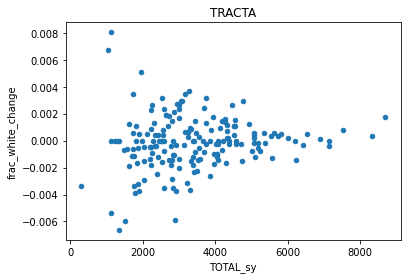

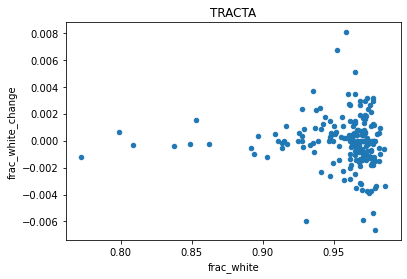

In [159]:
plot_frac_white_relationships(orig_df, 'SLDLA')
plot_frac_white_relationships(orig_df, 'SLDUA')
plot_frac_white_relationships(orig_df, 'COUNTYA')
plot_frac_white_relationships(orig_df, 'TRACTA')

It appears that larger changes happen for very homogeneous areas. This is consistent with our intuition that swapping should occur where there are few minorities.

## Regression for number of swaps
Here, we regress number of swaps in a region over racial entropy. We can add in other dependent variables here as we go.

In [93]:
def add_entropy(df):
    r_cols = ['W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE']
    r_cols = [c + '_sy' for c in r_cols]
    def before_entropy(row):
        ps = [row[c]/row['TOTAL_sy'] for c in r_cols]
        return sum(-p * np.log(p) for p in ps if p > 0)
    df['r_entropy'] = df.apply(before_entropy, axis=1)
    
def do_regression(df, col):
    grouped = get_aggregated_df(df, col)
    add_pct_white(grouped)
    add_entropy(grouped)
    print(grouped.columns)
    X = grouped[['r_entropy']]
    Y = grouped['swapped']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())

In [94]:
do_regression(orig_df, 'SLDLA')

Index(['TOTAL_sw', 'W_sw', 'B_sw', 'AI_AN_sw', 'AS_sw', 'H_PI_sw', 'OTH_sw',
       'TWO_OR_MORE_sw', 'NUM_HISP_sw', '18_PLUS_sw', 'swapped', 'NUM_HH',
       'TOTAL_sy', 'W_sy', 'B_sy', 'AI_AN_sy', 'AS_sy', 'H_PI_sy', 'OTH_sy',
       'TWO_OR_MORE_sy', 'NUM_HISP_sy', '18_PLUS_sy', 'frac_white_change',
       'frac_white', 'r_entropy'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                swapped   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     37.11
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           1.82e-08
Time:                        19:36:34   Log-Likelihood:                -678.08
No. Observations:                 108   AIC:                             1360.
Df Residuals:                     106   BIC:                             1366.
Df Mode

## Analyzing swapped pairs
Here, we try to get a sense for where swaps are occurring. How far is each swap? How many are within-region vs. across-region?

In [95]:
only_swaps = swapped_df[swapped_df['swapped'] == 1]
only_swaps.head()

,Unnamed: 0,YEAR,STATE,STATEA,COUNTY,COUSUBA,BLKGRPA,BLOCKA,NAME,BLOCK_TOTAL,...,identifier,freq,U,swapped,prob,TRACTA,COUNTYA,blockid,household.id,id
0,1,2010,Vermont,50,Bennington County,1450,2,1108,Block 2022,1,...,39707002022,14,4,1,1.0,970300,3,970700-003-2022,970300-003-1108-0001,970300-003-1108
1,2,2010,Vermont,50,Franklin County,59125,2,2034,Block 2046,1,...,11103002046,14,4,1,1.0,10300,11,010300-011-2046,010300-011-2034-0001,010300-011-2034
2,3,2010,Vermont,50,Grand Isle County,67000,4,4044,Block 4038,1,...,13202004038,14,4,1,1.0,20200,13,020200-013-4038,020200-013-4044-0001,020200-013-4044
3,4,2010,Vermont,50,Windham County,43375,2,1026,Block 2021,1,...,259682002021,14,4,1,1.0,967900,25,968200-025-2021,967900-025-1026-0001,967900-025-1026
4,5,2010,Vermont,50,Windsor County,84925,1,1000,Block 1018,1,...,279660001018,14,4,1,1.0,966000,27,966000-027-1018,966000-027-1000-0001,966000-027-1000


### Add geo data for source and destination blocks

In [96]:
def add_geos_from_blockid(df):
    block_df = block_df = pd.read_csv(get_block_file())
    block_df = block_df[['GISJOIN', 'COUNTYA', 'TRACTA', 'BLOCKA', 'SLDUA', 'SLDLA']]
    with_dest = df.merge(block_df,
                           how='inner',
                           on=['COUNTYA', 'TRACTA', 'BLOCKA'],
                           validate='many_to_one')
    make_identifier_synth(block_df)
    with_both = with_dest.merge(block_df,
                                  how='inner',
                                  left_on='blockid',
                                  right_on='id',
                                  suffixes=('_dest', '_source'),
                                  validate='many_to_one')
    map_dest = block_map.merge(with_both,
                            how='right',
                            left_on='GISJOIN',
                            right_on='GISJOIN_dest',
                            validate='one_to_many')
    del map_dest['GISJOIN_dest']
    map_both = block_map.merge(map_dest,
                               how='right',
                               left_on='GISJOIN',
                               right_on='GISJOIN_source',
                               suffixes=('_source', '_dest'),
                               validate='one_to_many')
    return map_both

In [97]:
swap_loc_df = add_geos_from_blockid(only_swaps)

In [98]:
swap_loc_df.head()

,STATEFP10_source,COUNTYFP10_source,TRACTCE10_source,BLOCKCE10_source,GEOID10_source,NAME10_source,MTFCC10_source,UR10_source,UACE10_source,FUNCSTAT10_source,...,id_dest,SLDUA_dest,SLDLA_dest,GISJOIN_source,COUNTYA_source,TRACTA_source,BLOCKA_source,SLDUA_source,SLDLA_source,id_source
0,50,003,970700,2022,500039707002022,Block 2022,G5040,None,None,S,...,970300-003-1108,BEN,B-5,G50000309707002022,3,970700,2022,BEN,B-5,970700-003-2022
1,50,011,010300,2046,500110103002046,Block 2046,G5040,None,None,S,...,010300-011-2034,E-O,F-6,G50001100103002046,11,10300,2046,E-O,F-6,010300-011-2046
2,50,011,010300,1020,500110103001020,Block 1020,G5040,None,None,S,...,010300-011-2034,E-O,F-6,G50001100103001020,11,10300,1020,E-O,F-6,010300-011-1020
3,50,011,010300,1020,500110103001020,Block 1020,G5040,None,None,S,...,010300-011-1025,E-O,F-6,G50001100103001020,11,10300,1020,E-O,F-6,010300-011-1020
4,50,011,010300,1020,500110103001020,Block 1020,G5040,None,None,S,...,010300-011-2064,E-O,F-6,G50001100103001020,11,10300,1020,E-O,F-6,010300-011-1020


In [99]:
def add_distance(df):
    def dist(row):
        return float(distance.distance((row['INTPTLAT10_source'], row['INTPTLON10_source']), (row['INTPTLAT10_dest'], row['INTPTLON10_dest'])).miles)
    df['distance'] = df.apply(dist, axis=1)

In [100]:
add_distance(swap_loc_df)

In [101]:
def get_swap_lines(df):
    s_pts = gpd.points_from_xy(df['INTPTLON10_source'], df['INTPTLAT10_source'])
    d_pts = gpd.points_from_xy(df['INTPTLON10_dest'], df['INTPTLAT10_dest'])
    lines = pd.Series([LineString([p1, p2]) for p1, p2 in zip(s_pts, d_pts)])
    return gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326").to_crs("EPSG:3395")

In [102]:
swap_lines = get_swap_lines(swap_loc_df)

/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Here are some basic statistics on the distance (in miles) for each swap.

Summary statistics for distance (miles):
count    24422.000000
mean         3.252964
std          6.691670
min          0.017270
25%          0.672228
50%          1.518584
75%          3.177222
max        154.906720
Name: distance, dtype: float64


array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

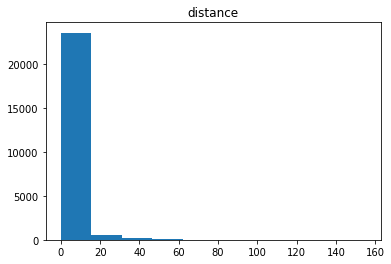

In [103]:
print('Summary statistics for distance (miles):')
print(swap_loc_df['distance'].describe())
swap_loc_df.hist(column=['distance'], grid=False)

We can also visualize the swapped pairs:

<AxesSubplot:title={'center':'Number of swaps'}>

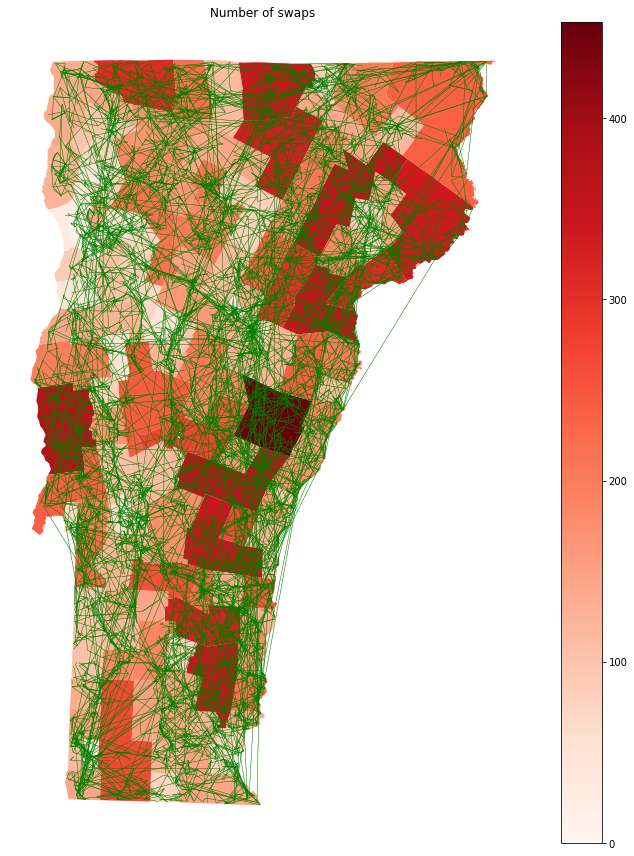

In [106]:
ax = plot_column(df, 'swapped', 'Number of swaps')
swap_lines.plot(ax=ax, color='green', linewidth=.3)

Next, we can look at how many swaps cross the boundary of any given region

In [164]:
def boundary_crossing(df, col):
    c1 = col + '_source'
    c2 = col + '_dest'
    # Divide by 2 because each swap involves 2 households so it's double-counted
    num = (df[c1] != df[c2]).sum()/2
    tot = len(df)/2
    print('%s: %d out of %d (%.3f%%)' % (col, num, tot, num/tot*100))

In [165]:
boundary_crossing(swap_loc_df, 'SLDLA')
boundary_crossing(swap_loc_df, 'SLDUA')
boundary_crossing(swap_loc_df, 'COUNTYA')
boundary_crossing(swap_loc_df, 'TRACTA')

SLDLA: 3543 out of 12211 (29.015%)
SLDUA: 1264 out of 12211 (10.351%)
COUNTYA: 1185 out of 12211 (9.704%)
TRACTA: 4242 out of 12211 (34.739%)
